In [1]:
import matplotlib.pyplot as plt
import numpy as np

from projects.common.nile import test_utils
from projects.diff_in_diff import project_config, common

In [2]:
cluster = project_config.get_project_cluster()

### Load experiment meta data

In [3]:
experiment_meta = common.get_experiment_meta('./experiment_configs/cash_2021-03-26.json')

In [4]:
experiment_meta

{'order_tariff_set': {'courier', 'express'},
 'order_source_set': {'yandex'},
 'exp_cities': {'Армавир',
  'Батайск',
  'Брянск',
  'Георгиевск',
  'Калининград',
  'Майкоп',
  'Новочеркасск',
  'Стерлитамак',
  'Чебоксары',
  'Элиста'},
 'exclude_cities': {'Белгород',
  'Брянск',
  'Волгоград',
  'Грозный',
  'Ижевск',
  'Калининград',
  'Ковров',
  'Москва',
  'Новосибирск',
  'Оренбург',
  'Ростов-на-Дону',
  'Рязань',
  'Санкт-Петербург',
  'Тольятти',
  'Тюмень',
  'Энгельс',
  'Южно-сахалинск'},
 'experiment_name': 'cash_2021-03-26',
 'ab_exp_start_dt': '2021-03-26',
 'ab_exp_end_dt': '2022-03-26',
 'ab_analysis_start_dt': '2021-03-05',
 'ab_analysis_end_dt': '2021-04-15',
 'aa_analysis_start_dt': '2021-02-12',
 'aa_analysis_end_dt': '2021-03-25',
 'aa_exp_start_dt': '2021-03-05'}

### Get table with metric of interest

In [5]:
df = test_utils.decode_dataframe(
    cluster
    .read('//home/taxi-delivery/analytics/dev/no_courier/agg_dm_order_v1_2020-11_2021-04')
    .as_dataframe()
)

In [6]:
df.head()

city order_tariff order_source utc_order_dt  trips_cnt  gmv_sum
0  Абакан      courier        cargo   2020-11-02          4    602.4
1  Абакан      courier        cargo   2020-11-06          4    637.2
2  Абакан      courier        cargo   2020-11-07          5    914.4
3  Абакан      courier        cargo   2020-11-08          3    472.8
4  Абакан      courier        cargo   2020-11-09          2    320.4

In [7]:
OUTCOME_VAR = 'trips_cnt'
TIME_VAR = 'utc_order_dt'
OBJECT_VAR = 'city'

In [8]:
df_proc = df[
    (df['order_source'].isin(experiment_meta['order_source_set']))
    & (df['order_tariff'].isin(experiment_meta['order_tariff_set']))
].groupby(['city', 'utc_order_dt']).sum().reset_index()
df_proc = df_proc[[OBJECT_VAR, TIME_VAR, OUTCOME_VAR]]

df_proc.head()

city utc_order_dt  trips_cnt
0  Абакан   2020-11-01         20
1  Абакан   2020-11-02         16
2  Абакан   2020-11-03         26
3  Абакан   2020-11-04         20
4  Абакан   2020-11-05         26

In [9]:
sdid_processor = common.SyntheticDiDDataProcessor(
    outcome_var=OUTCOME_VAR,
    time_var=TIME_VAR,
    object_var=OBJECT_VAR,
)

df_ab, df_aa = sdid_processor.process_data(
    df=df_proc,
    experiment_meta=experiment_meta,
    fillna_dict={'trips_cnt': 0}
)

In [10]:
df_aa.head()

city utc_order_dt  trips_cnt
0  Абакан   2021-02-12         37
1  Абакан   2021-02-13         33
2  Абакан   2021-02-14         48
3  Абакан   2021-02-15         17
4  Абакан   2021-02-16         17

In [11]:
df_ab.head()

city utc_order_dt  trips_cnt
0  Абакан   2021-03-05         49
1  Абакан   2021-03-06         45
2  Абакан   2021-03-07         48
3  Абакан   2021-03-08         68
4  Абакан   2021-03-09         35

### Perform AB and AA tests

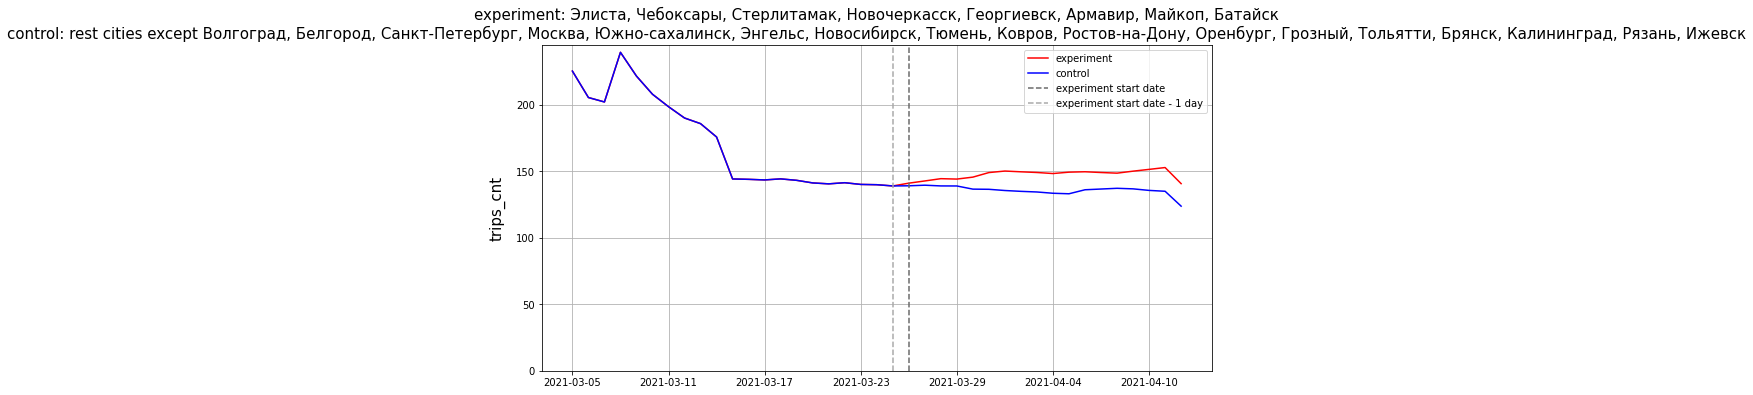

In [12]:
# AB test.
effect_ab = common.run_test(
    df_ab,
    treatment_start_date=experiment_meta['ab_exp_start_dt'],
    outcome_var=OUTCOME_VAR,
    time_var=TIME_VAR,
    object_var=OBJECT_VAR,
    treated_objects_set=experiment_meta['exp_cities'] - experiment_meta['exclude_cities'],
    skip_control_objects_set=experiment_meta['exclude_cities'],
    plot_flg=True,
    fig_save_path=None#'./outputs/charts/AB_{}.png'.format(experiment_meta['experiment_name'])
)

In [13]:
effect_ab

{'effect_abs': 268.462718555271, 'effect_rel': 0.10235924832914728}

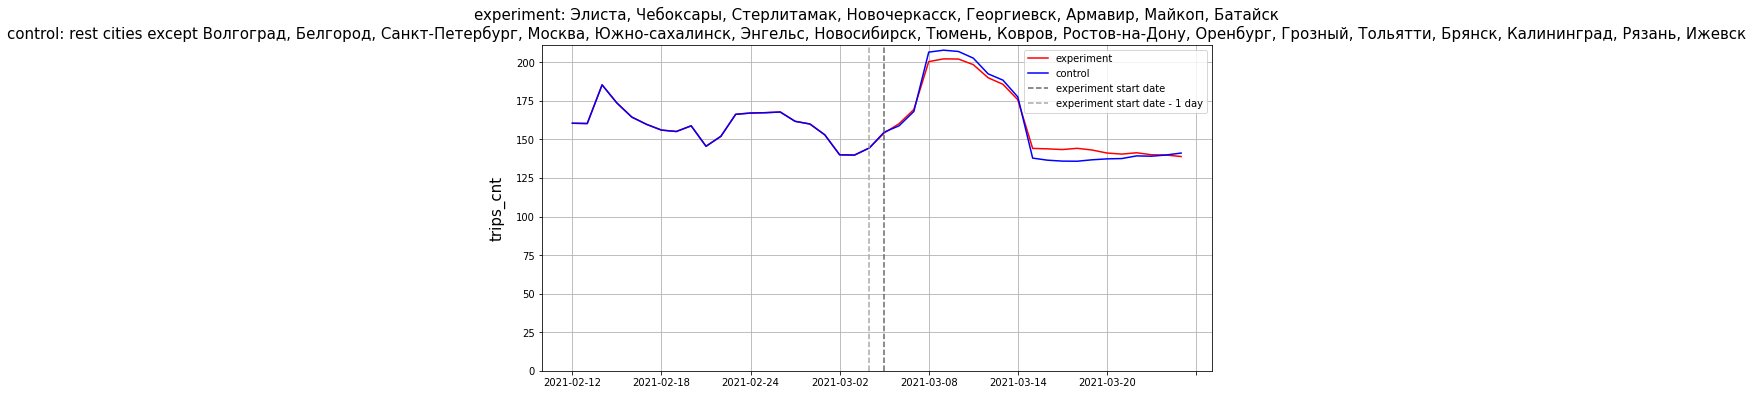

In [14]:
# AA Test 1: Time placebo test.
effect_aa = common.run_test(
    df_aa,
    treatment_start_date=experiment_meta['aa_exp_start_dt'],
    outcome_var=OUTCOME_VAR,
    time_var=TIME_VAR,
    object_var=OBJECT_VAR,
    treated_objects_set=experiment_meta['exp_cities'] - experiment_meta['exclude_cities'],
    skip_control_objects_set=experiment_meta['exclude_cities'],
    plot_flg=True,
    fig_save_path=None#'./outputs/charts/AB_{}.png'.format(experiment_meta['experiment_name'])
)

In [15]:
effect_aa

{'effect_abs': 13.319718259156474, 'effect_rel': 0.003950533721619834}

In [16]:
# AA Test 2: Space placebo test.
p_value, effect_rel_list = common.get_p_value(
    df=df_ab,
    effect=effect_ab['effect_rel'],
    experiment_meta=experiment_meta,
    treatment_start_date=experiment_meta['ab_exp_start_dt'],
    outcome_var=OUTCOME_VAR,
    time_var=TIME_VAR,
    object_var=OBJECT_VAR,
    n_iter=1000,
)

  0%|          | 0/1000 [00:00<?, ?it/s]

In [17]:
p_value

0.202

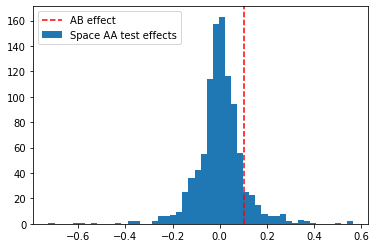

In [18]:
_ = plt.hist(effect_rel_list, bins=50, label='Space AA test effects')
plt.axvline(
    x=effect_ab['effect_rel'],
    label='AB effect',
    linestyle='--',
    color='red',
)
plt.legend()

### Generate experiment report

In [19]:
report = {
    'effect_abs': round(effect_ab['effect_abs'], 2),
    'effect_rel': round(effect_ab['effect_rel'], 3),
    'effect_aa_abs': round(effect_aa['effect_abs'], 2),
    'effect_aa_rel': round(effect_aa['effect_rel'], 3),
    'p_value': round(p_value, 3),
}
report.update(experiment_meta)

for key in ['order_tariff_set', 'order_source_set', 'exp_cities', 'exclude_cities']:
    report[key] = list(report[key])

In [20]:
report

{'effect_abs': 268.46,
 'effect_rel': 0.102,
 'effect_aa_abs': 13.32,
 'effect_aa_rel': 0.004,
 'p_value': 0.202,
 'order_tariff_set': ['courier', 'express'],
 'order_source_set': ['yandex'],
 'exp_cities': ['Элиста',
  'Чебоксары',
  'Стерлитамак',
  'Новочеркасск',
  'Георгиевск',
  'Армавир',
  'Майкоп',
  'Батайск',
  'Брянск',
  'Калининград'],
 'exclude_cities': ['Волгоград',
  'Белгород',
  'Санкт-Петербург',
  'Москва',
  'Южно-сахалинск',
  'Энгельс',
  'Новосибирск',
  'Тюмень',
  'Ковров',
  'Ростов-на-Дону',
  'Оренбург',
  'Грозный',
  'Тольятти',
  'Брянск',
  'Калининград',
  'Рязань',
  'Ижевск'],
 'experiment_name': 'cash_2021-03-26',
 'ab_exp_start_dt': '2021-03-26',
 'ab_exp_end_dt': '2022-03-26',
 'ab_analysis_start_dt': '2021-03-05',
 'ab_analysis_end_dt': '2021-04-15',
 'aa_analysis_start_dt': '2021-02-12',
 'aa_analysis_end_dt': '2021-03-25',
 'aa_exp_start_dt': '2021-03-05'}